# Misil

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, integrate, optimize

## Apartado 1

En primer lugar se introducen las variables geométricas del misil y las características del vuelo.

Variables geométricas:

In [19]:
D = 0.1778		# Diámetro del misil. (m)
r0 = D/2		# Radio del misil. (m)
l = 0.41		# Longitud de la ojiva. (m)
ang_ojiva = 2*np.arctan(D/(2*l)) # Ángulo de la ojiva
l_misil = 3.7	# Longitud del misil (m)
tr = 0.0055		# Ancho máximo de las alas. (m)
cr = 0.315      # Cuerda superficies de control. (m)
cdc = 0.5      	# Cf viscous crossflow.
m = 0.11        # Distancia borde de ataque a punto espesor máximo.
Bc = 0.615      # Wingspan (m)
deflx_w = 0.6	# Deflexión de la estela, término (1-dew/dalpha)
Bw = 0.517      # Wingspan ala (m)
Xcg = 2.19      # Distancia al centro de gravedad
Xcp = 2.46      # Distancia al centro de presiones
Xw = 1.91       # Distancia al centro de presiones del ala
Xb = 2.3        # Distancia al centro de presiones del fuselaje
Xc = 3.6675     # Distancia al centro de presiones del control
m_misil = 152	# Masa del misil (kg)
Sb = 10
Scontrol = 0.049641     # Superficie alar de los controles (m^2)
Sw = 0.0255             # Superficie alar (m^2)

Condiciones del vuelo:

In [20]:
AOA = 0 		# Ángulo de ataque (deg).
M = 4           # Mach de vuelo
h = 10000       # Altura de vuelo (m)
δ_deflx = 10    # Deflexión del control (deg)

En este apartado se ajustan las diferentes variables para que tengan las unidades requeridas, además de calcular otras variables que se precisen y que no sean introducidas por el usuario.

In [21]:
δ_deflx = δ_deflx*np.pi/180
AOA = np.pi*AOA/180
α = AOA
β = (M**2-1)**0.5                          # Parámetro de corrección de compresibilidad
ρ = (1.225*(1-22.558*10**(-6)*h)**4.2559)  # Densidad a la altura de vuelo
dens = ρ * 0.00194032
S = D*np.pi*(l_misil-l) +\
    np.pi*D/2*(l**2+(D/2)**2)**0.5 + Sw + \
    Scontrol  # Superficie del misil (m^2)
Sm_proyect = (l_misil-l)*D+0.17*np.cos(45*np.pi/180)*0.3+0.219 * \
	np.cos(45*np.pi/180)*0.315				# Superficie proyectada del misil
R_cte = 1718
Tinf = 1.8*(288.15-6.5*h/1000)
Patm = dens*Tinf*R_cte
Vsound = (1.4*Tinf*287)**0.5	# Velocidad del sonido a la altura de vuelo
Vinf = M*Vsound					# Velocidad de la corriente libre
mu0 = 3.58*10**(-7)  # Viscosidad en unidades del sistema imperial
dl = 50         # Divisiones del misil para las funciones de la capa límite.
g = 9.81		# Gravedad (m/s^2)
q = 1/2*Vinf**2*ρ


Para el cálculo de la resistencia generada en el misil como consecuencia del vuelo al Mach indicado, se ha tomado la gráfica disponible en el $\textit{Missile Aerodynamics}$ y se ha representado, interpolándose los diferentes valores que se obtienen de esta.

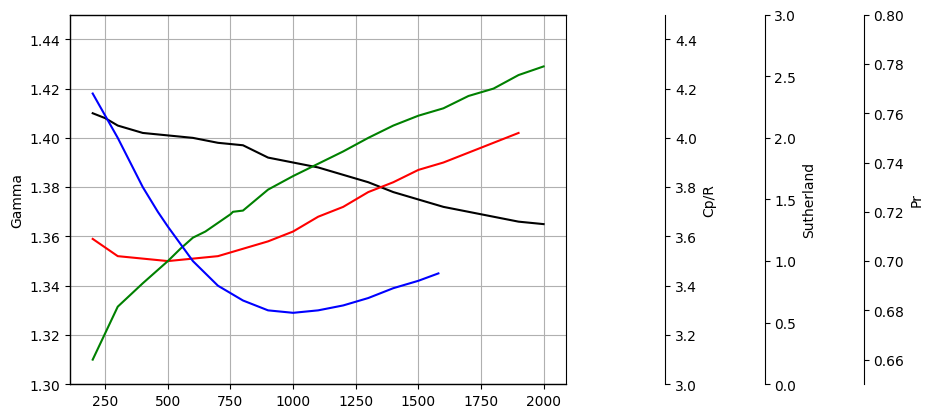

In [22]:
Temp_Pr = [200, 300, 350, 400, 460, 500, 600, 700, 800,
           850, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1580]
Pr_datos = [0.768, 0.75, 0.74, 0.73, 0.72, 0.714, 0.7, 0.69, 0.684,
            0.682, 0.68, 0.679, 0.68, 0.682, 0.685, 0.689, 0.692, 0.695]
Temp_gamma = [200, 250, 300, 400, 500, 600, 700, 800, 900, 1000,
              1100, 1200, 1300, 1350, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
gamma_datos = [1.41, 1.408, 1.405, 1.402, 1.401, 1.4, 1.398, 1.397, 1.392, 1.39,
               1.388, 1.385, 1.382, 1.38, 1.378, 1.375, 1.372, 1.37, 1.368, 1.366, 1.365]
Temp_cp = [200, 300, 400, 500, 600, 700, 800, 900, 1000,
           1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]
cp_datos = [3.59, 3.52, 3.51, 3.5, 3.51, 3.52, 3.55, 3.58,
            3.62, 3.68, 3.72, 3.78, 3.82, 3.87, 3.9, 3.94, 3.98, 4.02]
Temp_mu = [200, 300, 400, 500, 550, 600, 650, 700, 750, 760, 800, 900,
           1000, 1050, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
mu_datos = [0.2, 0.63, 0.82, 1, 1.1, 1.19, 1.24, 1.31, 1.38, 1.4, 1.41,
            1.58, 1.69, 1.74, 1.79, 1.89, 2, 2.1, 2.18, 2.24, 2.34, 2.4, 2.51, 2.58]
Pr = interpolate.CubicSpline(Temp_Pr, Pr_datos)
gamma = interpolate.CubicSpline(Temp_gamma, gamma_datos)
cp = interpolate.CubicSpline(Temp_cp, cp_datos)
mu = interpolate.CubicSpline(Temp_mu, mu_datos)
def Grafica_plot():
	fig, ax = plt.subplots()
	cp_pl = ax.twinx()
	muRel_pl = ax.twinx()
	Pr_pl = ax.twinx()
	cp_pl.plot(Temp_cp, cp(Temp_cp), 'r-', label="Cp/R")
	cp_pl.set_ylim(3, 4.5)
	cp_pl.spines.right.set_position(("axes", 1.2))
	cp_pl.set_ylabel("Cp/R")

	muRel_pl.plot(Temp_mu, mu(Temp_mu), 'g-', label="Sutherland")
	muRel_pl.spines.right.set_position(("axes", 1.4))
	muRel_pl.set_ylim(0, 3)
	muRel_pl.set_ylabel("Sutherland")

	Pr_pl.plot(Temp_Pr, Pr(Temp_Pr), 'b-', label="Prandtl")
	Pr_pl.set_ylim(0.65, 0.8)
	Pr_pl.spines.right.set_position(("axes", 1.6))
	Pr_pl.set_ylabel("Pr")

	ax.plot(Temp_gamma, gamma(Temp_gamma), "k-", label="Gamma")
	ax.set_ylim(1.3, 1.45)
	ax.set_ylabel("Gamma")
	ax.grid(True)
	plt.show()
Grafica_plot()

A continuación se procede a calcular los diferentes tipos de drag para obtener el total requerido.

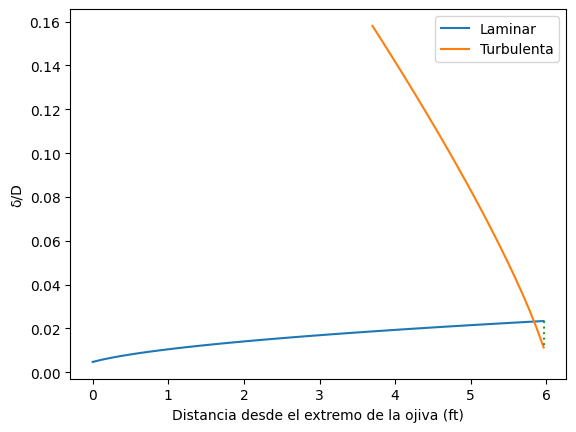

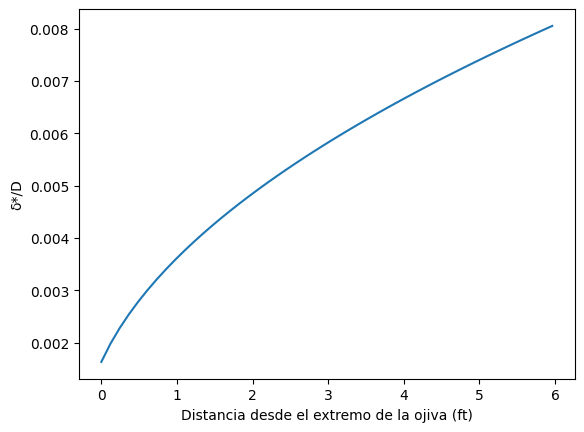

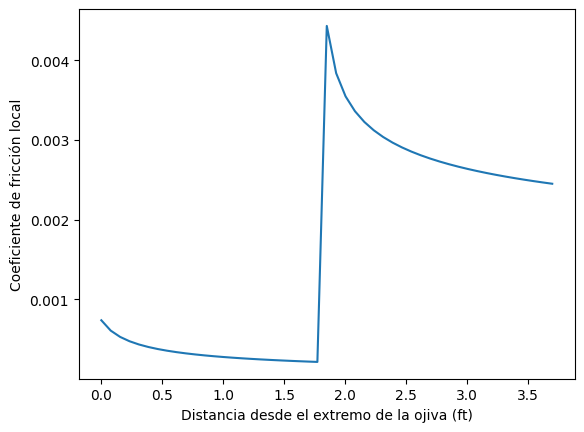

In [23]:
# El drag debido al lift en un cuerpo esbelto de base cilíndrica
# es la mitad del que se produce en una placa plana (Nielsen).
L_q = 2*np.pi*AOA*r0**2
# Resitencia debida a la sustentación / presión dinámica
D_q = 0.5*L_q*AOA
# Viscous Crossflow drag:
Sc = np.pi*r0**2   # Superficie transversal
# Viscous crossflow drag / presión dinámica
Dc_q = cdc*AOA**3*Sc
## RESISTENCIA FRONTAL
# Drag frontal en las alas para AOA = 0
Cd0 = 1/(4*m*(1-m))*4*(tr/cr)**2/β
# Drag frontal ojiva
Cdw = (0.083+0.096/M**2)*(ang_ojiva/10)**1.69 * \
    (1-(392*(l/D)**2-32)/(28*(M+18)*(l/D)**2))
## RESISTENCIA DE BASE
Cdb_s = 1
Cdb = Cdb_s * Sb/S
## RESISTENCIA DE FRICCIÓN
Vinf = (gamma(Tinf)*R_cte*Tinf)**0.5*M  # Velocidad de la corriente libre
# Función de cálculo de la densidad de referencia en la capa límite.
def dens_ref(T): return Patm/(R_cte*T)
def Re(x, ρ, μ): return Vinf*ρ*x/μ 					# Reynolds
# Coeficiente de fricción para caso laminar.
def cf_laminar(x, ρ, μ): return 0.664*Re(x, ρ, μ)**(-0.5)
def cf_turbulento(x, ρ, μ): return 0.370/(np.log10(Re(x, ρ, μ))**2.584)
def Laminar(T):
	"Función que calcula la capa límite laminar en función de la temperatura exterior"
	Titer = 1800						# Temperatura de inicio de la iteración
	Tref = Titer
	while True:
		r = Pr(Titer)**0.5
		Ts = T*(1+(gamma(T)-1)/2*M**2)
		Trec = T + r*(Ts-T)
		Tref = T + 0.5*(Trec-T)+0.22*r*(Ts-T)
		if abs(Titer-Tref) <= 0.00001:
			break
		Titer = Tref
	mu_ref = mu(Tref)*mu0
	# Promedio
	Re_medio = Re(x=l_misil*3.281, ρ=dens_ref(Tref), μ=mu_ref)
	cf_medio = 0.664*2/(Re_medio**0.5)
	# Local
	x_misil = np.linspace(0.5, l_misil*3.281, dl)
	cf_local = []
	i = 0
	while Re(x=x_misil[i], ρ=dens_ref(Tref), μ=mu_ref) < 10**7:
		# La capa límite laminar está presente hasta el punto de transición.
		cf_local.append(cf_laminar(x=x_misil[i], ρ=dens_ref(Tref), μ=mu_ref))
		i += 1
	xT = x_misil[i-1]
	θ = xT*cf_local[i-1]		# Momentum thickness
	δ = 5*x_misil/(Re(x=x_misil, ρ=dens_ref(Tref), μ=mu_ref)
	               ** 0.5)  # Espesor capa límite
	displ_thickness = 1.72*x_misil / \
		(Re(x=x_misil, ρ=dens_ref(Tref), μ=mu_ref)**0.5)  # Displacement thickness
	return cf_local, xT, θ, δ, dens_ref(Tref), cf_medio, displ_thickness
θ = Laminar(Tinf)[2]			# Punto de transición
xT = Laminar(Tinf)[1]			# Punto de transición
def Turbulenta(T, θ, xT):
	"Función que calcula la capa límite turbulenta en función de la temperatura exterior"
	Titer = 1800
	Tref = Titer
	while True:
		r = Pr(Titer)**(1/3)
		Ts = T*(1+(gamma(T)-1)/2*M**2)
		Trec = T + r*(Ts-T)
		Tref = T + 0.5*(Trec-T)+0.22*r*(Ts-T)
		if abs(Titer-Tref) <= 0.00001:
			break
		Titer = Tref
	mu_ref = mu(Tref)*mu0
	# Promedio
	Re_medio = Re(x=l_misil*3.281, ρ=dens_ref(Tref), μ=mu_ref)
	cf_medio = 0.455/(np.log10(Re_medio)**2.58)

	x_misil = np.linspace(0, l_misil*3.281, dl)
	cf_local = [cf_turbulento(x=coord, ρ=dens_ref(Tref), μ=mu_ref)
             for coord in x_misil if coord > 0]
	Δx = 0
	for i in range(0, len(x_misil)-1):
		θturb = x_misil[i]*cf_local[i]/2
		if abs(θturb - θ) < 0.000001:
			Δx = 2*θ/cf_local[i]  # Referencia Missile Aerodynamics
			break
	x_compensado = xT - Δx

	x_misil_compensado = [(coord - x_compensado) for coord in x_misil]
	def delta_BLayer(x, ρ, μ): return 0.37*x/(Re(x, ρ, μ)**(1/5))

	δ = [delta_BLayer(x=coord, ρ=dens_ref(Tref), μ=mu_ref)/(D*3.281)
            for coord in x_misil_compensado if coord > 0]
	cf_local = [cf_turbulento(x=coord, ρ=dens_ref(Tref), μ=mu_ref)
             for coord in x_misil_compensado if coord > 0]
	return cf_local, δ, dens_ref(Tref)
dens_lam, dens_turb, displ_thickness = Laminar(Tinf)[4], Turbulenta(Tinf, θ, xT)[
    2], Laminar(Tinf)[6]/(D*3.281)
BL_laminar = np.array(Laminar(Tinf)[0])
cf_local = np.append(BL_laminar, Turbulenta(Tinf, θ, xT)[0])
cf_local_func = interpolate.CubicSpline(
	np.linspace(0, l_misil, len(cf_local)), cf_local)
# Relación entre el espesor de la capa límite laminar y el diámetro del misil
delta_rel = Laminar(Tinf)[3]/(D*3.281)
# Relación entre el espesor de la capa límite turbulenta y el diámetro del misil
delta_rel_turb = Turbulenta(Tinf, θ, xT)[1]
def Plots():
	plt.figure(1)
	plt.plot(np.linspace(0, xT, len(delta_rel)), delta_rel, label='Laminar')
	plt.plot(np.linspace(xT, l_misil, len(delta_rel_turb)),
	         delta_rel_turb, label='Turbulenta')
	plt.plot([xT, xT], [delta_rel[-1], delta_rel_turb[0]], ':')
	plt.legend()
	plt.ylabel("δ/D")
	plt.xlabel("Distancia desde el extremo de la ojiva (ft)")

	plt.figure(2)
	plt.plot(np.linspace(0, xT, len(displ_thickness)), displ_thickness)
	plt.ylabel("δ*/D")
	plt.xlabel("Distancia desde el extremo de la ojiva (ft)")

	plt.figure(3)
	plt.plot(np.linspace(0, l_misil, len(cf_local)), cf_local)
	plt.ylabel("Coeficiente de fricción local")
	plt.xlabel("Distancia desde el extremo de la ojiva (ft)")
	plt.show()
Plots()
# Coeficiente de fricción medio. Se integra la función generada como suma de los coeficientes de fricción locales de la
# parte laminar y de la parte turbulenta
cf_medio_lam = integrate.quad(cf_local_func, 0, l)[
    0]*3**0.5 + integrate.quad(cf_local_func, l, xT)[0]
cf_medio_turb = integrate.quad(cf_local_func, xT, l_misil)[0]
Dfricc_lam, Dfricc_turb = cf_medio_lam * Vinf**2 / \
	2 * dens_lam, cf_medio_turb * Vinf**2/2*dens_turb

Dfricc = Dfricc_lam + Dfricc_turb				# En unidades del sistema imperial
def r_ojiva(x): return r0/l*x
# Integral de revolución para obtener el drag total
Dfricc_ojiva, Dfricc_fus = Dfricc_lam*2*np.pi*integrate.quad(r_ojiva, 0, l)[
    0], (xT - l)*Dfricc_lam*2*np.pi*r0*3.281 + 2*np.pi*r0*3.281*(l_misil-xT)*Dfricc_turb
Dfricc_misil = Dfricc_ojiva + Dfricc_fus


## Apartado 2


En la siguiente celda se adimensionalizan las distancias anteriormente introducidas.

In [24]:
Xcg = Xcg/D
Xcp = Xcp/D
Xw = Xw/D
Xb = Xb/D
Xc = Xc/D


In [25]:
CNic = 4/β
CNiw = 4/β
# Coeficiente de fuerza normal debido a alpha del fuselaje
Cnalpha_b = 2
# Coeficiente de fuerza normal debido a alpha del control
Cnalpha_c = (1+D/Bc)*Scontrol/Sm_proyect*CNic*deflx_w
# Coeficiente de fuerza normal debido a alpha de las alas
Cnalpha_w = CNiw*Sw/Sm_proyect*(1+D/Bw)
# Coeficiente de fuerza normal debido a alpha
Cn_alpha = Cnalpha_b + Cnalpha_c + Cnalpha_w
# Coeficiente de fuerza normal debido a delta
Cndelta_c = CNic*Scontrol/Sm_proyect*(1+D/Bc)


Con los anteriores coeficientes de fuerzas se obtiene la siguiente fuerza normal total (N).

In [26]:
Cn = Cn_alpha*α + Cndelta_c*δ_deflx
N = Cn*q*Sm_proyect; print("Fuerza normal: ", N)

Fuerza normal:  6146.409970353068


Por otro lado, los cálculos correspondientes a los momentos serían los siguientes:

In [27]:
# Momentos debidos a alpha y delta
Margen_estatico = (Cnalpha_b*(Xcg-Xb)+Cnalpha_c*(Xcg-Xc) +
                   Cnalpha_w*(Xcg-Xw))/(Cnalpha_b+Cnalpha_c+Cnalpha_w)
# Coeficiente de momentos debido al ángulo de ataque
Cm_alpha = Cn_alpha * Margen_estatico
# Coeficiente de momentos debido al ángulo del control
Cm_delta = Cndelta_c * (Xcg-Xc)

Siendo los coeficientes de momentos debidos al ángulo de ataque y deflexión del control los incluidos en Cm; los correspondientes a la aceleración angular en el giro, en Cm_ang; y los debidos al cambio de ángulo de ataque, Cm_AOA.

In [28]:
Cm = Cm_alpha * α + Cm_delta * δ_deflx
Cm_ang = -2*(Cnalpha_b*(Xcg-Xb)**2+Cnalpha_c*(Xcg-Xc)**2+Cnalpha_w*(Xcg-Xw)**2)
Cm_variacion_AOA = -2*CNic*(Sc/Sm_proyect*r0)*(1+D/Bc)*deflx_w*(Xc-Xw)*(Xc-Xcg)
print("Cm: " + str(Cm) +"\nCm_ang: " + str(Cm_ang) + "\nCm_AOA: " + str(Cm_variacion_AOA))

Cm: -0.14310955739567355
Cm_ang: -9.969633545671849
Cm_AOA: -0.4324647638883015


Finalmente, se indica la aceleración lateral obtenida en g's.

In [29]:
Cm_delta/Cm_ang

0.08224548684958456